## Objectiu: Predir si un pacient té una enfermetat cardiovascular en funció de les seves característiques clíniques.

### Carreguem llibreries i el dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler

dataset = pd.read_csv(".\\cardio_train.csv", sep=";")

## 1. Exploratory Data Analysis

Explorem la nostra base de dades, entenent quines són les característiques (dades que possiblement afectin al nostre objectiu) i l'objectiu (allò que volem predir). 

In [2]:
#PRINTEM INFORMACIÓ GENERAL SOBRE EL DATASET
print(dataset.describe(), "\n")
print(dataset.dtypes)

                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      0.680250    

El dataset està compost de 70.000 mostres de pacients i 12 característiques (informàcio mèdica del pacient). L'objectiu que tenim serà construir un model el més precís possible per predir si un pacient tindrà o no una malaltia cardiovascular, en funció de les seves dades mèdices i biològiques (com el sexe, l'edat, la pressió sanguínia sistòlica, etc). El nostre/s model/s realitzarà/n una tasca de **classificació**, marcant com a 0 aquells pacients que pensa que no tenen cap malaltia cardiovascular (classe negativa), o marcant com a 1 aquells pacients que pensa que tenen una malaltia cardiovascular (classe positiva).

Com que l'objectiu d'aquest treball és predir o no una enfermetat cardiovascular, tenim la intenció de minimitzar els falsos negatius (ja que fallar a l'hora d'identificar un pacient malalt -lo que seria un fals negatiu-, podria tener conseqüències molt greus, ja que començar un tractament a temps té moltes més probabilitats de salvar la vida del pacient que no si es comença tard), i també perquè és més acceptable tenir falsos positius (pacients que són diagnositcats amb una enfermetat però no la tenen realment) que no pas falsos negatius, creiem que la millor mètrica per avaluar els nostres models serà el **recall**, ja que aquesta mètrica mesura la capacitat d'un model per detectar correctament els casos positius dins de tots els casos positius reals. Sí que és veritat que hauríem d'evitar els falsos positius (pacients diagnosticats falsament), però com que el diagnòstic és una etapa inicial, un resultat positiu només porta cap a més proves, no directament cap a un tractament invasiu, per tant, és millor fallar detectant més casos suspitosos per garantir que cap malalt real no sigui detectat.

És important mencionar que el Dataset té tres tipus diferents de característiques (features):

1. Característiques objectives (informació objectiva, com el sexe, l'edat, el pes...)
2. Característiques d'examinació (resultats de proves mèdiques, com la pressió sanguínia sistòlica, els nivells de glucosa...)
3. Característiques subjectives (informació proporcionada pel pacient, com el nivell d'activitat física, la quantitat d'alcohol i de tabac que consumeix...)

Variables de la base de dades:

0. id --> Índex de les mostres. Numèric quantitatiu continu.
1. age --> Edat del pacient (dies). Numèric quantitatiu discret (encara que a vegades es classifica com a continu).
2. height --> Alçada del pacient (cm). Numèric quantitatiu continu.
3. weight --> Pes del pacient (kg). Numèric quantitatiu continu.
4. gender --> Gènere del pacient (0, 1). Categòric qualitatiu binari.
5. ap_hi --> Pressió arterial sistòlica del pacient (mmHg). Numèric quantitatiu continu.
6. ap_lo --> Pressió arterial diastòlica del pacient (mmHg). Numèric quantitatiu continu.
7. cholesterol --> Nivell de colesterol del pacient (1: normal, 2: per sobre del normal, 3: molt per sobre del normal). Categòric qualitatiu ordinal.
8. gluc --> Nivell de glucosa del pacient (1: normal, 2: per sobre del normal, 3: molt per sobre del normal). Categòric qualitatiu ordinal.
9. smoke --> Fumar o no (0: no, 1: sí). Categòric qualitatiu binari.
10. alco --> Consum d'alcohol (0: no, 1: sí). Categòric qualitatiu binari.
11. active --> Activitat física (0: no, 1: sí). Categòric qualitatiu binari.
12. cardio --> Presència o absència de malaltia cardiovascular (0: no, 1: sí). Categòric qualitatiu binari.

Tenim 12 característiques i 1 target ("cardio").

Volem predir "cardio" (presència o absència de malaltia cardiovascular en un pacient) en funció de totes les altres característiques.

Ara que ja coneixem quines són les nostres dades, podem veure que caldrà, durant l'etapa de Preprocessing, **estandaritzar** les següents columnes:

-"height"

-"weight"

-"ap_hi"

-"ap_lo"

Estandaritzarem aquestes variables perquè són numèriques contínues que tenen rangs molt amplis (la diferència entre el mínim i el màxim és molt gran, per exemple, la diferència entre els dos límits de l'interval de la variable "weight" és de 190 unitats).

Recordem que l'estandardització és important per uniformitzar les escales de les variables, millorant l'eficiència dels models basats en distàncies o gradients, com K-NN o xarxes neuronals, i permetent una penalització uniforme en models amb regularització.

In [3]:
# SEPAREM features (X) I target (y)
X=dataset.drop('cardio',axis=1)
y=dataset['cardio']

In [4]:
print("\nMostrem els primers valors de les característiques i de l'objectiu:\n")
print(X.head())


Mostrem els primers valors de les característiques i de l'objectiu:

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  
0     0       1  
1     0       1  
2     0       0  
3     0       1  
4     0       0  


In [5]:
print(y.head())

0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64


Anem a veure si les nostres dades presenten NaNs:

In [6]:
print("\nNombre de NaNs per columna en els features:\n")
print(X.isna().sum())
print("\nPercentatge de NaNs per columna en els features:\n")
print(X.isna().mean() * 100)


Nombre de NaNs per columna en els features:

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64

Percentatge de NaNs per columna en els features:

id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
dtype: float64


In [7]:
print("\nNombre de NaNs per columna en el target:\n")
print(y.isna().sum())
print("\nPercentatge de NaNs per columna en el target:\n")
print(y.isna().mean() * 100)


Nombre de NaNs per columna en el target:

0

Percentatge de NaNs per columna en el target:

0.0


No tenim NaNs (valors buits) ni en el nostre objectiu ni en les característiques.

D'altra banda, hi ha algunes característiques, concretament "age" (edat) i "height" (altura), que estan expresades en dies i centímetres, respectivament.

Si en el nostre treball fos molt important tenir un control molt específic de l'edat del pacient (per exemple, quan els pacients són nounats i tenen pocs dies de vida), llavors estaria bé tenir les dades en dies, ja que es requeriria una precisió màxima, però quan no treballem en aquests casos concrets, tenir una variable d'edat expresada en dies pot resultar en una interpretació poc intuitiva i generar problemes d'escala en alguns models. En la següent gràfica podem observar la distribució de la variable "age", expresada en anys, per saber si estem parlant de pacients nounats o de grups de pacients d'una edat concreta, o de pacients de qualsevol edat:

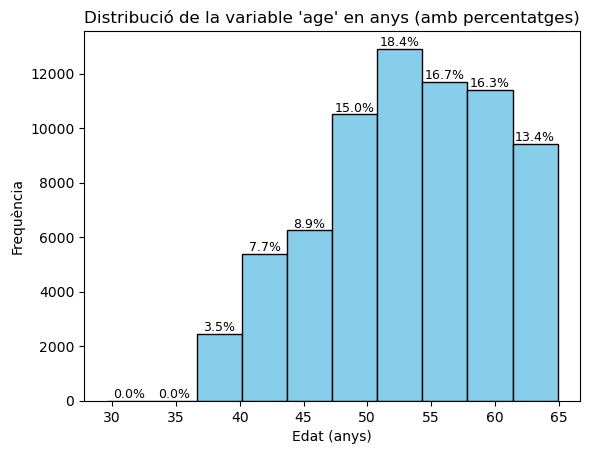

In [8]:
frequencies, bins, patches = plt.hist(X["age"]/365.25, bins=10, edgecolor='black', color='skyblue', density=False)
percentages = (frequencies / frequencies.sum()) * 100
for i in range(len(patches)):
    plt.text(
        patches[i].get_x() + patches[i].get_width() / 2,
        patches[i].get_height(),                         
        f"{percentages[i]:.1f}%",                        
        ha='center', va='bottom', fontsize=9, color='black'
    )
plt.title("Distribució de la variable 'age' en anys (amb percentatges)")
plt.xlabel("Edat (anys)")
plt.ylabel("Frequència")
plt.show()

Com podem observar, el número de pacients no es concentra en grups d'edats molt específics, i per tant no necessitem tenir tanta precisió en la variable "age".

Per tant, quan arribem a la fase de preprocessing, haurem d'expresar aquesta variable en una altra unitat, que serà els "anys", ja que és la unitat per defecte en els anàlisis mèdics.

També podem examinar la distribució de la variable "height":

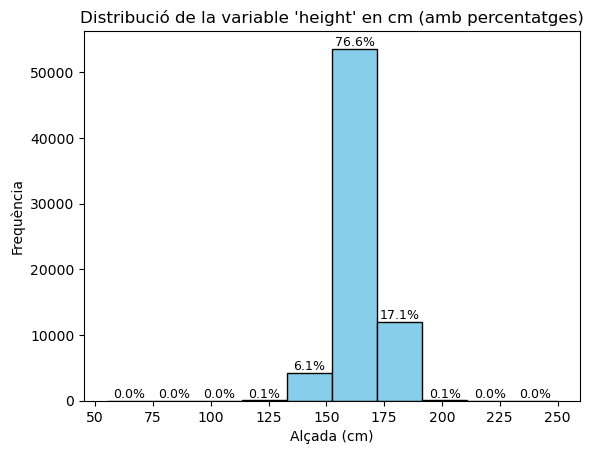

In [9]:
frequencies, bins, patches = plt.hist(X["height"], bins=10, edgecolor='black', color='skyblue', density=False)
percentages = (frequencies / frequencies.sum()) * 100
for i in range(len(patches)):
    plt.text(
        patches[i].get_x() + patches[i].get_width() / 2,
        patches[i].get_height(),                         
        f"{percentages[i]:.1f}%",                        
        ha='center', va='bottom', fontsize=9, color='black'
    )
plt.title("Distribució de la variable 'height' en cm (amb percentatges)")
plt.xlabel("Alçada (cm)")
plt.ylabel("Frequència")
plt.show()

Aquí sí que observem que la variable "height" està concentrada en grups de valors específics, sobretot en el grup d'entre 150 i 175 centímetres (76.6% de les mostres). En aquest cas sí que seria interessant tenir els valors expresats en una unitat que permeti als models tenir sensibilitat als petits canvis que hi hagi en les diferents mostres, per tant, deixarem la variable alçada expresada en centímetres, en lloc d'expresar-la en metres (que és la unitat estàndard).

A més a més, és normal que en dades clíniques s'utilitzi com a unitat de l'alçada els centímetres.

Ara anem a veure les distribucions de les altres variables que encara no hem vist:

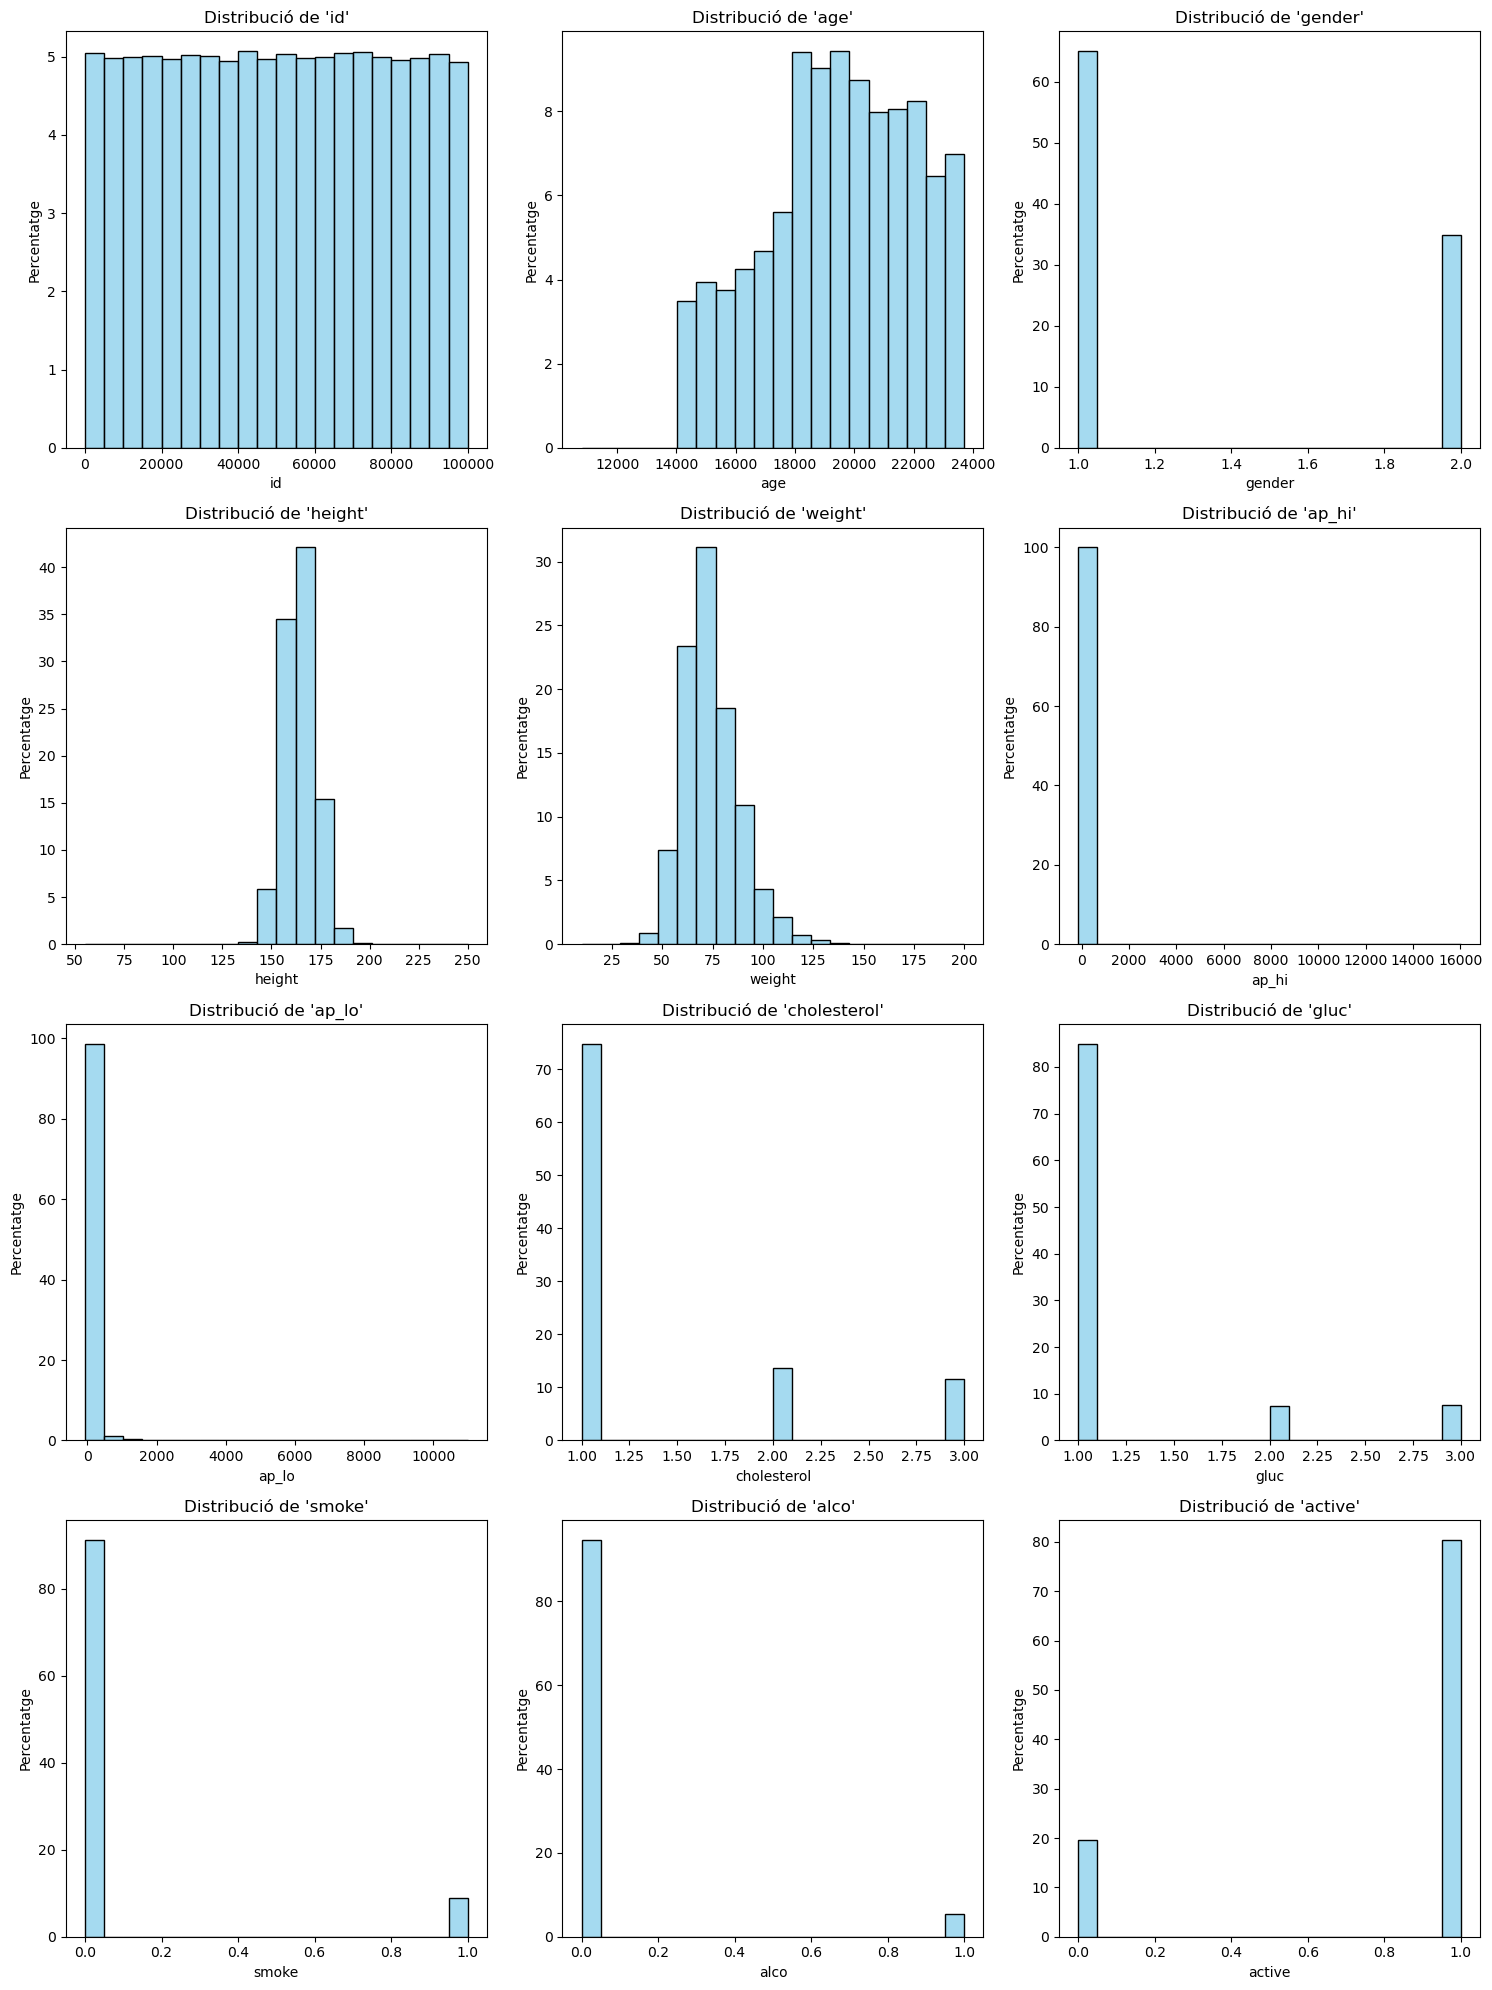

In [10]:
n_cols = 3
n_rows = len(X.columns) // n_cols + (len(X.columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(X.columns):
    sns.histplot(X[column], kde=False, bins=20, stat="percent", color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribució de '{column}'")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Percentatge")

for i in range(len(X.columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Podem observar que hi ha variables categòriques desbalancejades, com "smoke", "cholesterol", "gender", "alco", "active" o "gluc". Per tant, podria ser interessant aplicar SMOTE o alguna altra tècnica de balanceig de dades quan arribem a la part de preprocessing. Per comprovar si és realment necessari aplicar una tècnica de balanceig de dades, podem observar la relació que té cada classe amb el target: si totes les classes de cada variable desbalancejada tenen una relació similar amb el target, el desbalanceig podria no ser problemàtic, però si les classes minoritàries tenen un patró diferent, és important corregir els desbalanceig.

In [11]:
print(pd.crosstab(X['smoke'], y, normalize='index'), "\n")
print(pd.crosstab(X['cholesterol'], y, normalize='index'), "\n")
print(pd.crosstab(X['gender'], y, normalize='index'), "\n")
print(pd.crosstab(X['alco'], y, normalize='index'), "\n")
print(pd.crosstab(X['active'], y, normalize='index'), "\n")
print(pd.crosstab(X['gluc'], y, normalize='index'), "\n")

cardio         0         1
smoke                     
0       0.497893  0.502107
1       0.525207  0.474793 

cardio              0         1
cholesterol                    
1            0.559893  0.440107
2            0.397843  0.602157
3            0.234565  0.765435 

cardio         0         1
gender                    
1       0.503273  0.496727
2       0.494769  0.505231 

cardio         0         1
alco                      
0       0.499426  0.500574
1       0.515675  0.484325 

cardio         0         1
active                    
0       0.464226  0.535774
1       0.509109  0.490891 

cardio         0         1
gluc                      
1       0.519410  0.480590
2       0.406936  0.593064
3       0.377978  0.622022 



Com podem observar, totes les variables excepte "cholesterol" i "gluc" tenen classes que, encara que estiguin desbalancejades, tenen un impacte similar en el target. Altrament, "cholesterol" i "gluc" tenen classes amb un impacte significatiu en el target: per exemple, tenir un colesterol molt alt ("cholesterol"=3, que és una classe minoritària) implica una probabilitat del 76% de tenir una malaltia cardiovascular, mentre que un colesterol baix ("cholesterol"=1) implica una probabilitat del 44% de tenir una malaltia cardiovascular (en el nostre dataset). Passa el mateix amb la variable "gluc".

Per tant, per aquestes dues variables hauríem d'aplicar alguna tècnica de balanceig, com SMOTE o simple resampling. És important fer-ho perquè les classes minoritàrias contenen informació que pot ser crucial per predir el target. Si aquestes classes estan subrepresentades en les dades, el model pot no aprendre correctament el seu impacte en la predicció, perquè no les podrà "estudiar" tant com si ho farà amb les classes superrepresentades.

D'altra banda, sembla ser que hi ha variables amb valors molt extrems, com "ap_hi" o "ap_Io". Anem a mostrar ara les distribucions amb mapes de punts (scatters), per veure-ho més clarament:

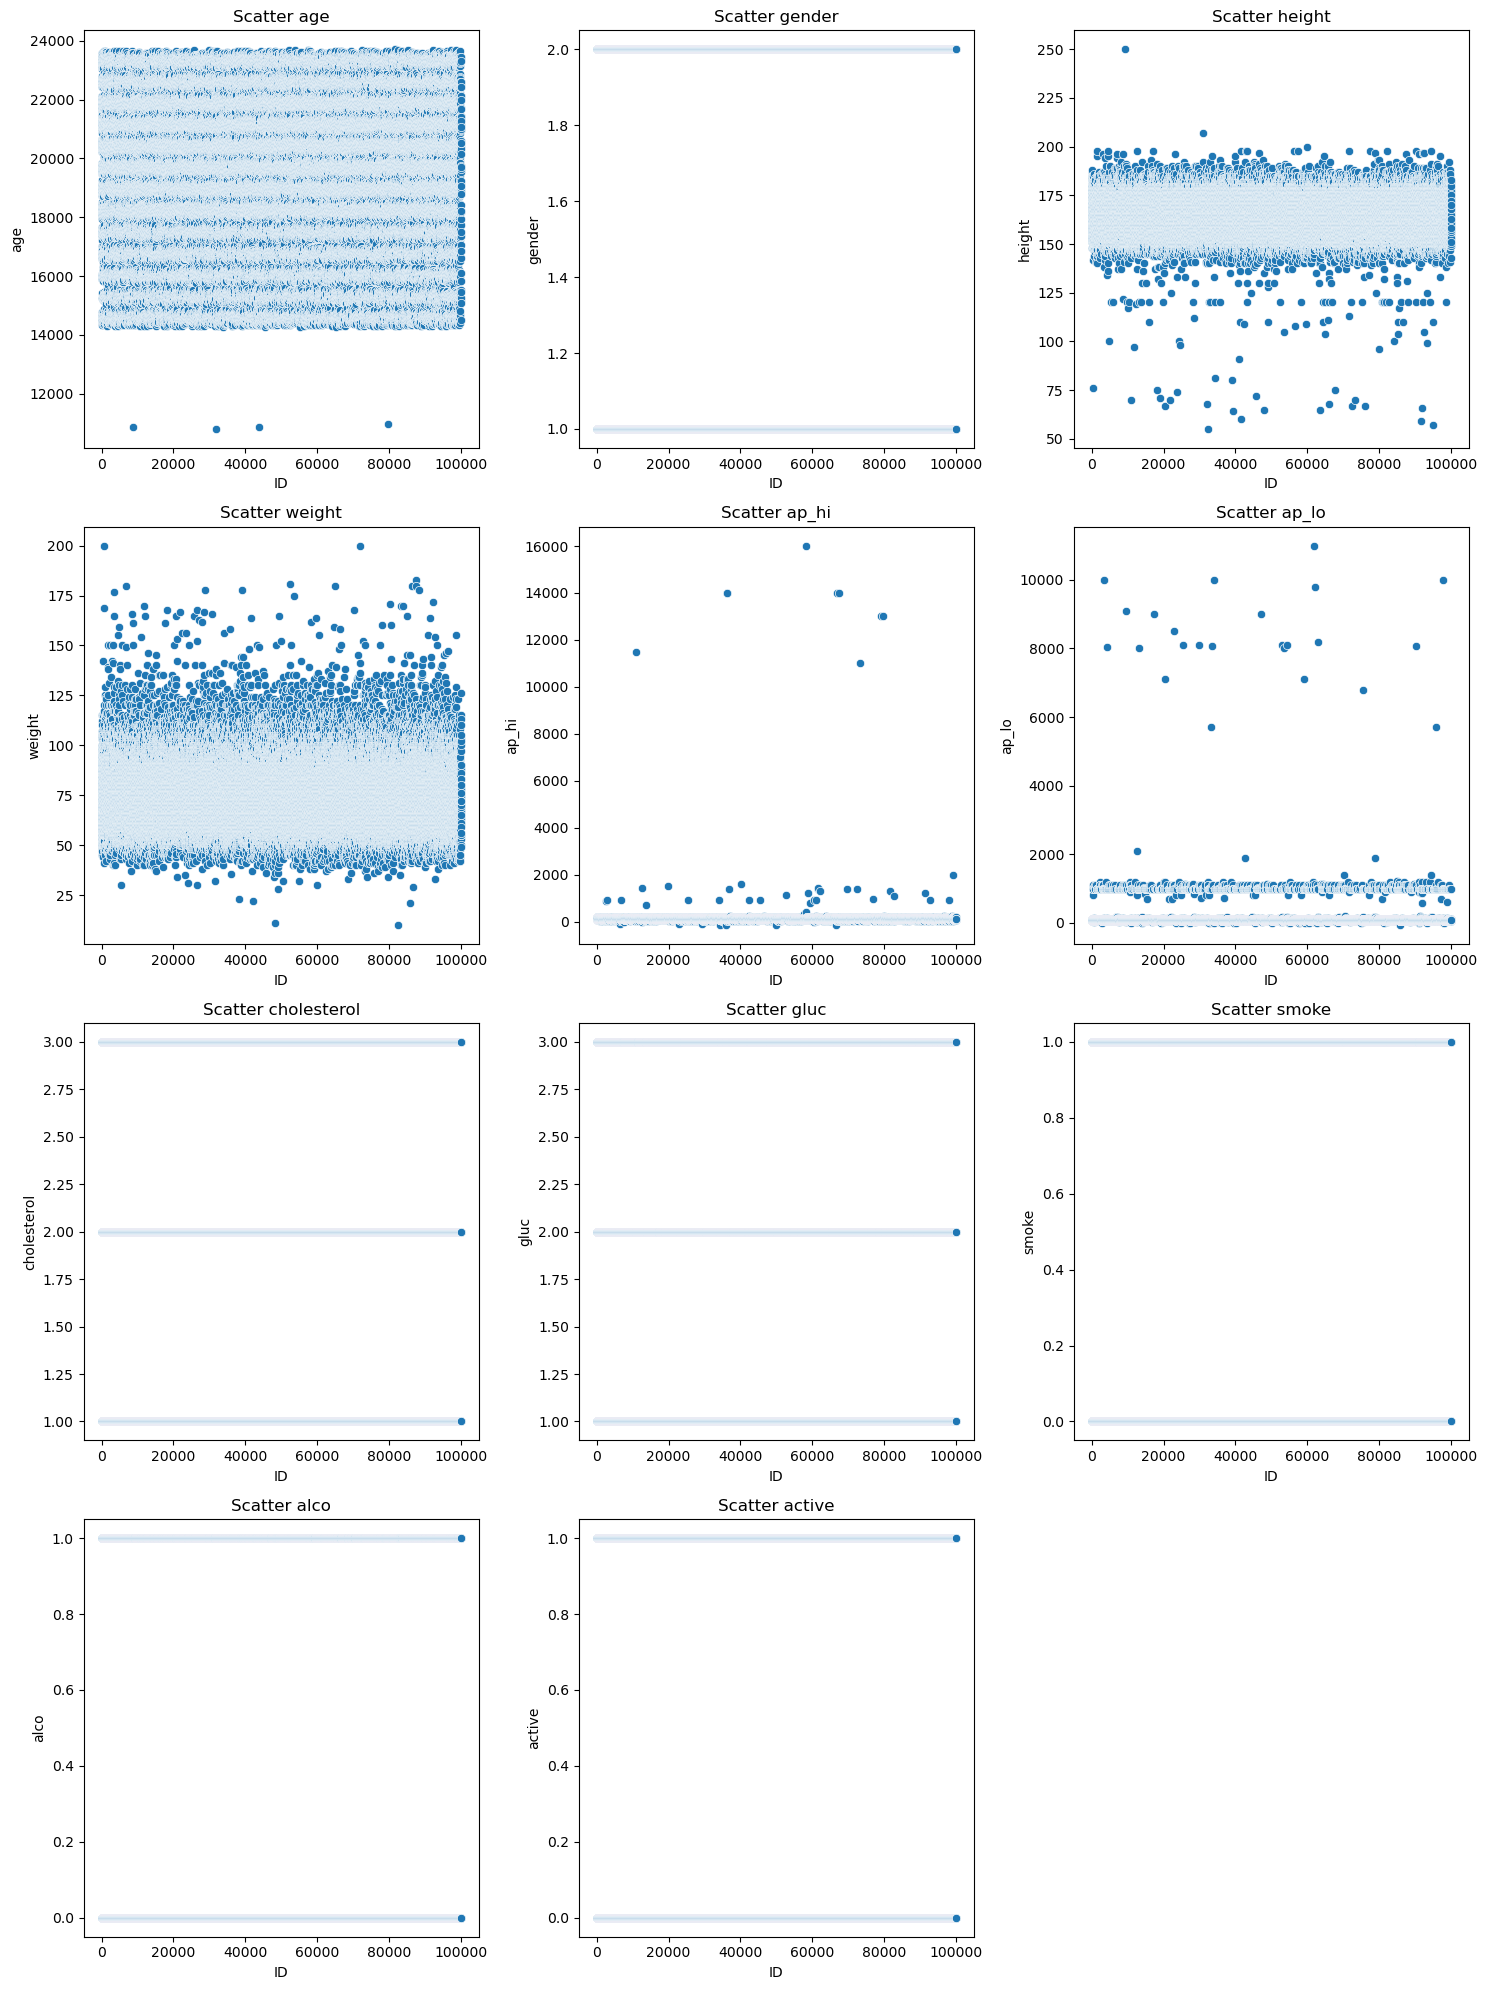

In [12]:
X_sense_ID = X.drop(columns=["id"])

n_cols = 3
n_rows = len(X_sense_ID.columns) // n_cols + (len(X_sense_ID.columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(X_sense_ID.columns):
    sns.scatterplot(x=X["id"], y=X[col], ax=axes[i])
    axes[i].set_title(f"Scatter {col}")
    axes[i].set_xlabel("ID")
    axes[i].set_ylabel(col)
    
for i in range(len(X_sense_ID.columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Podem observar que hi ha variables amb valors outliers, com "weight", "height" i "age", que s'escapen dels grups de valors on es concentra la resta de les dades:

-"Weight": Dades majorment concentrades entre 50 i 120 kg, amb valors que es desvien uniformement fins a 175 kg per sobre i fins a 25 kg per sota. Més enllà hi ha alguns pocs valors outliers, d'entre els quals destaquen dos de 200 kg.

-"Height": Dades majorment concentrades entre 150 i 180 cm. Veiem que hi ha diverses mostres per sota de 150 cm i un outlier prop de 250 cm. Aquest valor és gairebé impossible que sigui real i per tant l'haurem de treure durant el preprocessing.

-"Age": Dades majorment concentrades entre 14.000 i 24.000 dies (ja ho hem vist abans), alguns valors outliers per sota (prop dels 10.000 dies). De moment no els eliminarem, perquè ens poden servir perque el model aprengui de pacients més joves, tot i que potser podrien provocar overfitting (si finalment tenim overfitting, ja ens encarregarem de treure'ls).

També hi ha dos variables, "ap_hi" i "ap_lo", que tenen valors outliers extrems:


In [13]:
print("ap_hi:\n\n", X["ap_hi"].describe())
print("\n\nap_lo:\n\n", X["ap_lo"].describe())

ap_hi:

 count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64


ap_lo:

 count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64


Per a "ap_hi" veiem que el valor màxim (16020) és 125 vegades superior al valor de la mitjana (128), amb altres valors (que hem vist als scatters) també molt superiors als normals.

Per "ap_lo" veiem que el valor màxim (11000) és 114 vegades superior al valor de la mitjana (96), i també hem vist altres mostres amb valors massa elevats (per sobre de 6000).

També és important notar que hi ha fins i tot valors negatius, la qual cosa no té cap sentit biològic.

Tots aquests valors el hem d'interpretar com a errors de medició o relacionats amb problemes de codificació o processament de dades, ja que és impossible que cap persona pugui arribar a tenir aquests valors de pressió sanguínia, i no els podem deixar en el nostre dataset ja que podrien provocar overfitting.

Si ens fixem en l'scatter de la variable "ap_lo", veiem que hi ha molts valors concentrats al voltant dels 1.300 mmHg. Aquests valors també són impossibles d'assolir, però sembla que són molts valors, i si eliminimem masses valors el model podria no entrenar-se correctament. Anem a veure el nombre de mostres concentrades entorn als 1.300 mmHg:

In [14]:
print("\nNombre de mostres amb 'ap_lo' concentrades entorn als 1.300 mmHg:\n")
print(((X["ap_lo"] > 600) & (X["ap_lo"] < 1500)).sum())


Nombre de mostres amb 'ap_lo' concentrades entorn als 1.300 mmHg:

925


925 mostres són aproximadament el 1.3% del total de les dades (70.000 mostres), per tant, com que tampoc representen un alt porcentatge del nombre de mostres, i a més són mostres que contenen valors impossibles, ens podem permetre eliminar-los, sense afectar greument a l'entrenament del model.

Per evitar confondre al model amb valors fisiològicament impossibles (que cap èsser humà ha assolit ni es pensa que pugui assolir mai), definirem un intervals de valors acceptables per a les variables "ap_io", "ap_lo", "weight" i "height", que són les variables contínues del nostre dataset.

Aquests intervals tindràn en compte no només els valors sans, sinó també els insans (que són precísament els que ens interessen, per poder detectar si hi ha relacions o no entre aquestes variables i el target). El que no volem tenir en compte són els valors impossibles.

Els intervals, que agafen els valors "possibles" de les 4 variables abans nombrades i que a més, se'ls hi ha afegit una extensió de tolerància (per poder agafar també valors anòmals), són els següents (tenint present que l'edat mínima de la nostra base de dades és de 29 anys, ja que aquests intervals canviarien si els pacients fossin nens):


"weight" --> [30, 250] (de 10 a 250 kilograms)

"height" --> [55, 220] (de 5 a 220 centímetres)

"ap_lo" --> [8, 180] (de 8 a 180 mmHg)

"ap_hi" --> [40, 400] (de 40 a 400 mmHg)

Considerem que tots els valors fora dels intervals anteriors són impossibles (o gairebé impossibles) d'assolir i, per tant, no els tindrem en compte en la nostra base de dades (els eliminarem durant el preprocessing).

A la part de distribucions, només ens queda ara mostrar la distribució del target ("cardio"):

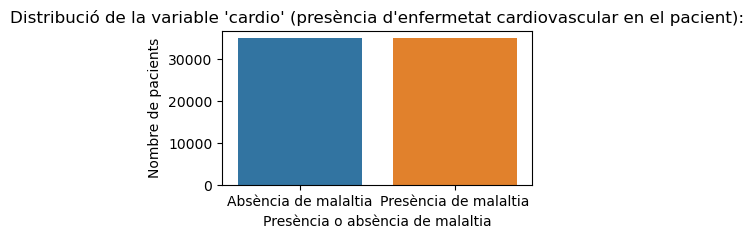

cardio
0    35021
1    34979
Name: count, dtype: int64
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64


In [15]:
plt.figure(figsize=(4, 2))
sns.countplot(x=y, data=X)
plt.title("Distribució de la variable 'cardio' (presència d'enfermetat cardiovascular en el pacient):")
plt.xlabel('Presència o absència de malaltia')
plt.ylabel('Nombre de pacients')
plt.xticks(ticks=[0, 1], labels=['Absència de malaltia', 'Presència de malaltia'])
plt.show()

counts = y.value_counts()
print(counts)

proportions = y.value_counts(normalize=True)
print(proportions)

Podem observar que les dues classes tenen gairebé la mateixa distribució (estan balancejades), per tant, no ens caldrà realitzar cap mètode de balanceig al target.

Ara que ja hem parlat sobre les distribucions de les dades, anem a mostrar la matriu de correlacions, per veure quines dades estan o no correlacionades entre elles, i quina informació en podem treure:

<Axes: >

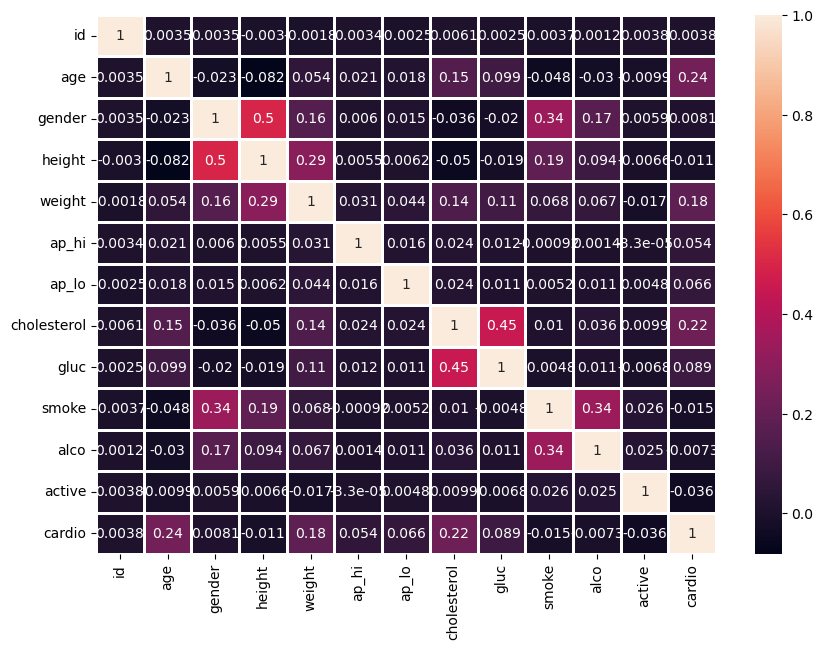

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(pd.concat([X,y],axis=1).corr(),annot=True,linewidths=2)

Donada la matriu de correlacions, podem observar les següentes correlacions entre features:

-"gender" i "height": Correlació positiva de 0.5, això vol dir que com més alt és "gender", més alt serà "height", i viceversa. Aquesta correlació té sentit, ja que, habitualment, els homes (codificats com a 2) són més alts que les dones (codificats com a 1). Podem conservar ambdues variables ja que la correlació no és extremadament alta i el model pot aprendre la relació.

-"gender" i "weight": Correlació positiva de 0.16, pel mateix motiu que em mencionat abans amb l'alçada.

-"height" i "weight": Correlació positiva de 0.29. Té sentit, ja que com més altes són les persones, més solen pesar. Podríem conservar ambdues variables, ja que la correlació no és alta i creiem que el pes té un efecte important a l'hora de parlar de malalties cardiovasculars (després ho veurem). Tot i això, una millor estratègia podria ser fusionar les dues variables en una, l'IMC (o índex de massa corporal, BMI en anglès), que és una mesura que relaciona el pes i l'alçada per estimar si té un pes saludable. Construir una variable IMC (i eliminar les variables "height" i "weight") pot ser beneficiós per diversos motius, però sobretot perquè suposa una reducció de la dimensionalitat (menys variables, per tant, un model que costarà menys entrenar), proporciona una relació més informativa (IMC és una mesura habitual de la salut de les persones, més que el pes o l'alçada per separats) i per simplificar el dataset. Llavors, el que farem amb aquestes dues variables, quan arribem a la fase de preprocessing, serà crear una nova columna "BMI" que les substitueixi.

-"gender" i "smoke": Correlació positiva de 0.34. Ens indica que els homes fumen més que les dones. Si més endavant veiem que una de les dos variables està correlacionada amb el target i l'altra no, podríem eliminar una de les dues, per simplificar el dataset i l'entrenament del model.

-"height" i "smoke": Correlació positiva de 0.19. Ens indica que com més pesa un pacient, més probabilitat té de fumar. A priori, aquesta relació no té gaire sentit (no hi ha cap raó que indiqui que fumar fa que una persona creixi, o que les persones altes fumin més).

-"gender" i "alco": Correlació positiva de 0.17. Ens indica que els homes tenen més probabilitat de veure més alcohol que les dones.

-"cholesterol" i "gluc": Correlació positiva de 0.45. Ens indica que com més colesterol té una persona, més glucosa té, i viceversa. Segons Més endavant veurem que ambdues variables estan relaciones amb el target. De moment ens quedarem amb les dues, però si el model presenta overfitting, podríem eliminar la variable "gluc" (per tener una menor correlació amb el target) o crear una variable combinada.

Ara veiem les relacions més importants entre features i target:

-"age" i "cardio": Correlació positiva de 0.24. Ens indica que les perones més grans tenen més probabilitat de tenir una enfermetat cardiovascular.

-"weight" i "cardio": Correlació positiva de 0.18. Ens indica que les persones amb més pes tenen més probabilitat de tenir una enfermetat cardiovascular.

-"cholesterol" i "cardio": Correlació positiva de 0.22. Ens indica que les persones amb més colesterol en sang tenen més probabilitat de tenir una enfermetat cardiovascular.

-"gluc" i "cardio": Correlació positiva  de 0.089. És inferior a la correlació que té el target amb "cholesterol", per tant, si el model amb les dades actuals presenta resultats pobres, podríem provar eliminant "gluc" (ja que "cholesterol" presenta informació semblant, llavors es simplificaria el model).

-"ap_hi" i "cardio": Correlació positiva de 0.054. És una relació petita, però no tant com altres variables.

-"ap_lo" i "cardio": Correlació positiva de 0.066. També es una relació petita, llavors si veiem que el model es torna molt complexe, podríem també provar d'eliminar les variables "ap_hi" i "ap_lo", per veure si millora.

-Variables subjectives ("alco", "smoke" i "active") i "cardio": Contràriament al que ens podríem pensar en un inici, aquestes variables tenen una correlació ínfima (i en el cas de "alco" i "active", la relació és fins i tot inversa) amb tenir o no enfermetats cardiovasculars. Gràcies als coneixements mèdics [1][2] que tenim en l'actualitat, sabem que l'alcohol, el tabac i el sedentarisme són estils de vida que poden conduir més fàcilment a contraure una enfermetat cardiovascular, llavors podem pensar que les nostres dades podrien no ser correctes, o bé perquè el pacient ha mentit a l'hora de contestar sobre els seus estils de vida, o bé perquè hi ha hagut errors de transcripció a les dades, o simplement perquè hi ha hagut la casualitat que les mostres recollides en aquesta base de dades no són com les d'altres datasets amb els que s'han fet els experiments que han demostrat que l'alcohol, el tabac i la falta d'activitat física estan molt correlacionats positivament amb la contracció de malalties cardiovasculars. Per estar segurs del que ens diu la matriu de correlacions, anem a mostrar ara les agrupacions de les variables subjectives amb el target.

In [17]:
print(pd.concat([X,y],axis=1)[["smoke","cardio"]].groupby(["smoke"], as_index = False).mean().sort_values(by="cardio"))
X['smoke'].value_counts()[1]

   smoke    cardio
1      1  0.474793
0      0  0.502107


6169

In [18]:
print(pd.concat([X,y],axis=1)[["alco","cardio"]].groupby(["alco"], as_index = False).mean().sort_values(by="cardio"))
X['alco'].value_counts()[1]

   alco    cardio
1     1  0.484325
0     0  0.500574


3764

In [19]:
print(pd.concat([X,y],axis=1)[["active","cardio"]].groupby(["active"], as_index = False).mean().sort_values(by="cardio"))
X["active"].value_counts()[0]

   active    cardio
1       1  0.490891
0       0  0.535774


13739

Veiem que, com ja ens deia la matriu de correlacions, en el nostre dataset, els pacients que fumen o beuen alcohol tenen menys probabilitat de tenir una enfermetat cardiovascular que els pacients que no fumen o no beuen. D'altra banda, fer activitat física presenta menys probabilitats de tenir una enfermetat cardiovascular que no fer activitat física, però la diferència és d'un 4%, i en un principi pensàvem que seria més gran.

El que farem serà conservar les dades subjectives, i si veiem que el model presenta uns resultats pobres, probarem el model sense les variables subjectives, per veure si millora o no.

Finalment, per acabar amb la part d'EDA, i abans de començar el Preprocessing, farem la divisió entre les dades d'entrenament i les de prova. Les dades d'entrenament les utilitzarem per entrenar els diversos models que construirem, i també per validar-los. D'altra banda, el conjunt de test quedarà aillat fins que haguem acabat la validació, i haguem seleccionat el millor model, i l'utilitzarem només per obtenir un recall -i altres mètriques- final que avaluin definitivament el nostre treball.

Reservarem, com és usual, un 20% del total de dades per al conjunt de test, i farem l'split de manera que les classes, en cada subconjunt, quedin balancejades (amb l'opció stratify=y).

També farem còpies dels datasets abans de tractar-los, per tenir accès a les dades originals en cas que les necessitem.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_original = X_train.copy(deep=True)
X_test_original = X_test.copy(deep=True)
y_train_original = y_train.copy(deep=True)
y_test_original = y_test.copy(deep=True)

També és important mencionar que, durant la fase de preprocessing, haurem d'eliminar la columna "id", ja que només s'utilitza per indexar les dades i no té cap relació (com també es pot veure a la matriu de correlacions) amb el target.

## 2. Preprocessing

Aplicarem els tractaments que hem anat mencionant durant l'EDA. S'han de fer tots els passos tant en el conjunt de train com en el de test, per evitar data leakage.

1. Passem els valors de la variable "age" a anys (en comptes de mantenir els valors en dies), per guanyar interpretació i evitar problemes d'escala.

In [21]:
print(X_train["age"].head(), "\n")

X_train["age"] = X_train["age"] / 365.25
X_test["age"] = X_test["age"] / 365.25

print("\n", X_train["age"].head())

58394    18995
60371    17319
41399    19017
11468    20388
20650    18236
Name: age, dtype: int64 


 58394    52.005476
60371    47.416838
41399    52.065708
11468    55.819302
20650    49.927447
Name: age, dtype: float64


2. Eliminar valors de les variables discretes "weight", "height", "ap_lo" i "ap_hi" que estiguin fora dels intervals establerts durant l'EDA, ja que no són valors reals. Si es tractés d'outliers normals, s'eliminaríen només en el dataset d'entrenament, però no es tracta de valors outliers, sinó de valors impossibles (com hem vist abans, per exemple, que hi havia pacients amb una pressió sanguínea negativa). Per tant, els hem d'eliminar tant del conjunt d'entrenament com del conjunt de prova.

    "weight" --> [30, 250] (de 10 a 250 kilograms)

    "height" --> [55, 220] (de 5 a 220 centímetres)

    "ap_lo" --> [8, 180] (de 8 a 180 mmHg)

    "ap_hi" --> [40, 400] (de 40 a 400 mmHg)

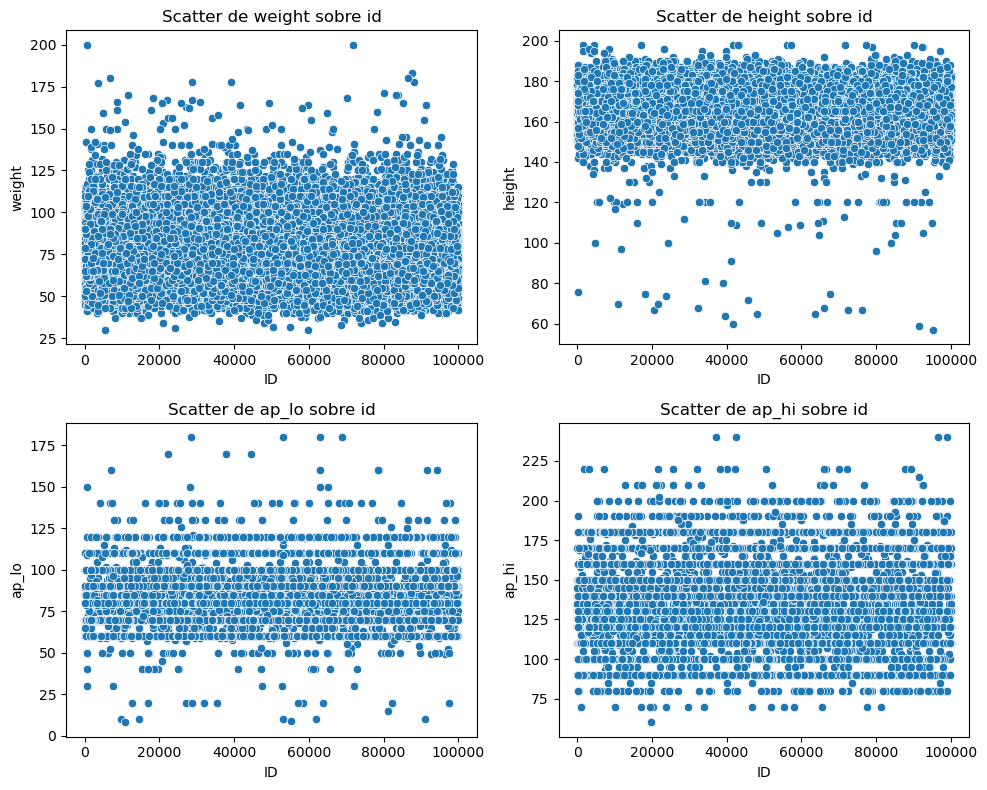

0 0

Número de mostres eliminades per contenir valors irreals:

Train:  965
Test:  240


In [22]:
columnes = ['weight', 'height', 'ap_lo', 'ap_hi']
intervals = [(30, 250), (55, 220), (8, 180), (40, 400)]

for columna, interval in zip(columnes, intervals):
    mask_train = (X_train[columna] >= interval[0]) & (X_train[columna] <= interval[1])
    mask_test = (X_test[columna] >= interval[0]) & (X_test[columna] <= interval[1])
    
    # APLIQUEM MÀSCARES PER CONSERVAR NOMÉS ELS VALORS VÀLIDS
    X_train = X_train[mask_train]
    y_train = y_train[mask_train]
    
    X_test = X_test[mask_test]
    y_test = y_test[mask_test] 
    
# MOSTREM LES NOVES DISTRIBUCIONS, PER VEURE SI HEM ELIMINAT ELS VALORS IRREALS

n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))
axes = axes.flatten()
for i, columna in enumerate(columnes):
    sns.scatterplot(x=X_train['id'], y=X_train[columna], ax=axes[i])
    axes[i].set_title(f'Scatter de {columna} sobre id')
    axes[i].set_xlabel('ID')
    axes[i].set_ylabel(columna)
plt.tight_layout()
plt.show()

print(X_train.isna().sum().sum(), X_test.isna().sum().sum())
print("\nNúmero de mostres eliminades per contenir valors irreals:\n")
print("Train: ", X_train_original.shape[0]-X_train.shape[0])
print("Test: ", X_test_original.shape[0]-X_test.shape[0])

Com podem observar, ja no existeixen valors irreals (o almenys hem eliminat la major part), però ara el que tenim són valors extrems (outliers que sí que poden ser reals). Com que el número de valors "normals" és molt més gran que el número d'outliers, de moment no cal que ens preocupem per aquests outliers, però si el rendiment del model no acaba de ser del tot bò, podem provar a eliminar-los.

3. Creem una columna "BMI" (índex de massa corporal) a partir de les variables "weight" y "height".

In [23]:
# FÒRMULA IMC: pes / alçada^2. Pes en kg i alçada en m

X_train['BMI'] = X_train['weight'] / (X_train['height'] / 100) ** 2
X_test['BMI'] = X_test['weight'] / (X_test['height'] / 100) ** 2

print(X_train.head())

          id        age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
58394  83327  52.005476       2     162    83.0    120     80            1   
60371  86196  47.416838       1     158    64.0    120     80            1   
41399  59158  52.065708       1     165    95.0    160    100            2   
11468  16399  55.819302       1     164    83.0    150    100            1   
20650  29470  49.927447       1     156    52.0    100     67            1   

       gluc  smoke  alco  active        BMI  
58394     1      0     0       0  31.626276  
60371     1      0     0       1  25.636917  
41399     1      0     0       1  34.894399  
11468     1      0     0       1  30.859607  
20650     1      0     0       0  21.367521  


4. Eliminar les columnes 'weight' i 'height' per disminuir la dimensionalitat (ja estan representades per la columna 'BMI').

In [24]:
X_train = X_train.drop(columns=['weight', 'height'])
X_test = X_test.drop(columns=['weight', 'height'])

print(X_train.head())

          id        age  gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
58394  83327  52.005476       2    120     80            1     1      0     0   
60371  86196  47.416838       1    120     80            1     1      0     0   
41399  59158  52.065708       1    160    100            2     1      0     0   
11468  16399  55.819302       1    150    100            1     1      0     0   
20650  29470  49.927447       1    100     67            1     1      0     0   

       active        BMI  
58394       0  31.626276  
60371       1  25.636917  
41399       1  34.894399  
11468       1  30.859607  
20650       0  21.367521  


5. Afegir mostres de les classes "2" i "3" a la variable "cholesterol" per tal de balancejar-la. Abans hem vist que la classe "1" (colesterol baix) representava més del 70% del total de les mostres, i això pot afectar negativament al rendiment del model. Realitzarem oversampling simple (duplicació de valors seleccionats aleatòriament) per equilibrar la variable. No podem utilitzar SMOTE perquè és un mètode que està dissenyat específicament per el target, no per els features.

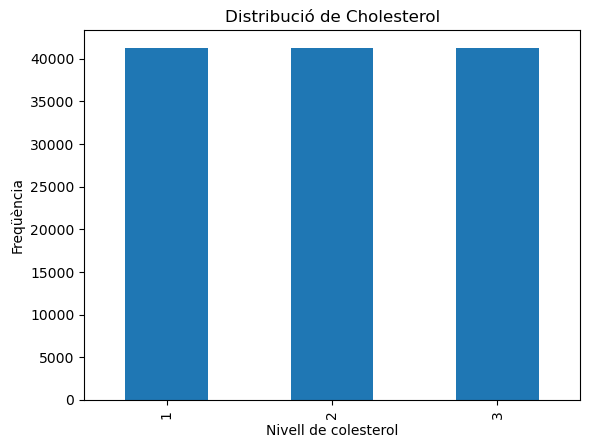

                  id            age         gender          ap_hi  \
count  123819.000000  123819.000000  123819.000000  123819.000000   
mean    50199.448235      54.216215       1.328899     129.684709   
std     28866.139887       6.557370       0.469815      17.678769   
min         0.000000      29.730322       1.000000      60.000000   
25%     25190.000000      49.894593       1.000000     120.000000   
50%     50580.000000      55.299110       1.000000     130.000000   
75%     75031.000000      59.652293       2.000000     140.000000   
max     99999.000000      64.865161       2.000000     240.000000   

               ap_lo  cholesterol           gluc          smoke  \
count  123819.000000  123819.0000  123819.000000  123819.000000   
mean       82.759035       2.0000       1.453662       0.091222   
std        10.164874       0.8165       0.762142       0.287926   
min         8.000000       1.0000       1.000000       0.000000   
25%        80.000000       1.0000       1.0

In [25]:
# SEPAREM LES CLASSES MAJORITÀRIES I MINORITÀRIES (HO FEM TANT EN X_train COM EN y_train, ES SELECCIONARAN LES MATEIXES MOSTRES EN FEATURE I EN TARGET)

major_class_1 = X_train[X_train['cholesterol'] == 1]
minor_class_2 = X_train[X_train['cholesterol'] == 2]
minor_class_3 = X_train[X_train['cholesterol'] == 3]

y_train_class_1 = y_train[X_train['cholesterol'] == 1]
y_train_class_2 = y_train[X_train['cholesterol'] == 2]
y_train_class_3 = y_train[X_train['cholesterol'] == 3]

# REALITZEM OVERSAMPLING SIMPLE

minor_class_2_oversampled = resample(minor_class_2,
                                     replace=True, 
                                     n_samples=len(major_class_1),
                                     random_state=42)
y_train_minor_class_2_oversampled = resample(y_train_class_2,
                                            replace=True, 
                                            n_samples=len(major_class_1),
                                            random_state=42)

minor_class_3_oversampled = resample(minor_class_3,
                                     replace=True,
                                     n_samples=len(major_class_1),
                                     random_state=42)
y_train_minor_class_3_oversampled = resample(y_train_class_3,
                                            replace=True,
                                            n_samples=len(major_class_1),
                                            random_state=42)

# COMBINEM TOTES LES CLASSES I RESTABLIM ELS ÍNDEXS DELS DATAFRAMES PER EVITAR PROBLEMES

X_train = pd.concat([major_class_1, minor_class_2_oversampled, minor_class_3_oversampled]).reset_index(drop=True)
y_train = pd.concat([y_train_class_1, y_train_minor_class_2_oversampled, y_train_minor_class_3_oversampled]).reset_index(drop=True)

# OBSERVEM ELS RESULTATS DEL RESAMPLING

X_train['cholesterol'].value_counts().plot(kind='bar')
plt.title('Distribució de Cholesterol')
plt.xlabel('Nivell de colesterol')
plt.ylabel('Freqüència')
plt.show()

print(X_train.describe(), "\n")
print(y_train.describe(), "\n")

print(pd.crosstab(X_train['cholesterol'], y_train, normalize='index'), "\n")


Observem que ara les tres classes estan balancejades i la relació de cada classe amb el target continua éssent igual que abans, per tant, el resampling s'ha realitzat correctament.

6. Repetim el procés, però ara amb la variable "gluc": afegir mostres de les classes "2" i "3" a la variable "gluc" per tal de balancejar-la. Abans hem vist que la classe "1" (nivells baixos de glucosa) representava més del 80% del total de les mostres, i això pot afectar negativament al rendiment del model.

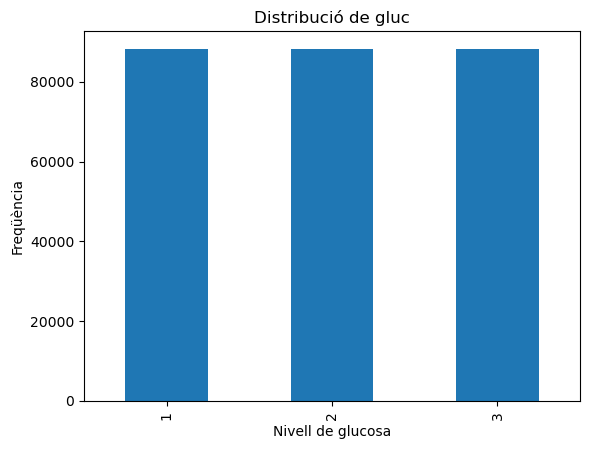

                  id            age         gender          ap_hi  \
count  264789.000000  264789.000000  264789.000000  264789.000000   
mean    50261.683340      54.639565       1.318167     130.826911   
std     28847.458876       6.433812       0.465765      18.106857   
min         0.000000      29.730322       1.000000      60.000000   
25%     25190.000000      50.234086       1.000000     120.000000   
50%     50759.000000      55.693361       1.000000     130.000000   
75%     75068.000000      59.811088       2.000000     140.000000   
max     99999.000000      64.865161       2.000000     240.000000   

               ap_lo    cholesterol           gluc          smoke  \
count  264789.000000  264789.000000  264789.000000  264789.000000   
mean       83.414251       2.221153       2.000000       0.088297   
std        10.403194       0.760574       0.816498       0.283726   
min         8.000000       1.000000       1.000000       0.000000   
25%        80.000000       2.0000

In [26]:
# SEPAREM LES CLASSES MAJORITÀRIES I MINORITÀRIES (HO FEM TANT EN X_train COM EN y_train, ES SELECCIONARAN LES MATEIXES MOSTRES EN FEATURE I EN TARGET)

major_class_1 = X_train[X_train['gluc'] == 1]
minor_class_2 = X_train[X_train['gluc'] == 2]
minor_class_3 = X_train[X_train['gluc'] == 3]

y_train_class_1 = y_train[X_train['gluc'] == 1]
y_train_class_2 = y_train[X_train['gluc'] == 2]
y_train_class_3 = y_train[X_train['gluc'] == 3]

# REALITZEM OVERSAMPLING SIMPLE

minor_class_2_oversampled = resample(minor_class_2,
                                     replace=True, 
                                     n_samples=len(major_class_1),
                                     random_state=42)
y_train_minor_class_2_oversampled = resample(y_train_class_2,
                                            replace=True, 
                                            n_samples=len(major_class_1),
                                            random_state=42)

minor_class_3_oversampled = resample(minor_class_3,
                                     replace=True,
                                     n_samples=len(major_class_1),
                                     random_state=42)
y_train_minor_class_3_oversampled = resample(y_train_class_3,
                                            replace=True,
                                            n_samples=len(major_class_1),
                                            random_state=42)

# COMBINEM TOTES LES CLASSES I RESTABLIM ELS ÍNDEXS DELS DATAFRAMES PER EVITAR PROBLEMES

X_train = pd.concat([major_class_1, minor_class_2_oversampled, minor_class_3_oversampled]).reset_index(drop=True)
y_train = pd.concat([y_train_class_1, y_train_minor_class_2_oversampled, y_train_minor_class_3_oversampled]).reset_index(drop=True)

# OBSERVEM ELS RESULTATS DEL RESAMPLING

X_train['gluc'].value_counts().plot(kind='bar')
plt.title('Distribució de gluc')
plt.xlabel('Nivell de glucosa')
plt.ylabel('Freqüència')
plt.show()

print(X_train.describe(), "\n")
print(y_train.describe(), "\n")

print(pd.crosstab(X_train['gluc'], y_train, normalize='index'), "\n")


Tal i com ha passat amb la variable "cholesterol", les tres classes de "gluc" ara estan balancejades i la relació de cada classe amb el target continua éssent igual, per tant, el resampling s'ha realitzat correctament.

No cal que balancegem les altres variables categòriques com "smoke", "alco" i "active" perquè hem vist que són variables amb un efecte baix en el target.

7. Estandaritzar les variables "BMI", "ap_lo" i "ap_hi". Com hem anat veient al llarg d'aquest informe, aquestes variables són numèriques continues, i per tant és important estandaritzar-les per facilitar l'entrenament dels models. Les dues opcions per estandaritzar més comunes són l'Standard Scaler i el Robust Scaler, el Robust Scaler és el més recomenat quan les variables que s'han d'estandaritzar tenen valors atípics. Com ja hem mencionat abans, i com podem veure també a continuació, les tres variables que volem estandaritzar tenen valors outliers:

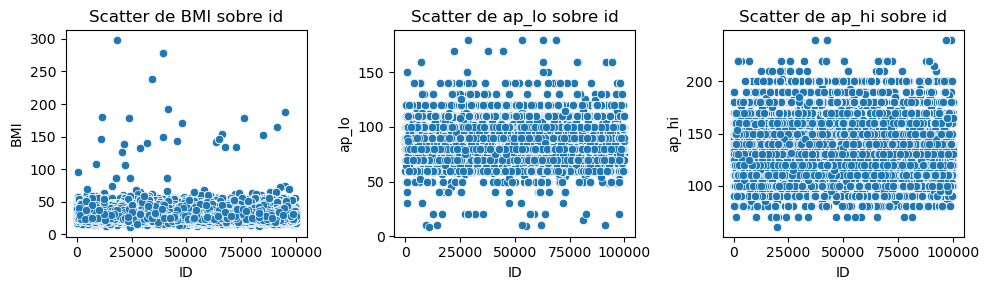

In [27]:
n_cols = 3
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3))
axes = axes.flatten()
columnes = ["BMI", "ap_lo", "ap_hi"]
for i, columna in enumerate(columnes):
    sns.scatterplot(x=X_train['id'], y=X_train[columna], ax=axes[i])
    axes[i].set_title(f'Scatter de {columna} sobre id')
    axes[i].set_xlabel('ID')
    axes[i].set_ylabel(columna)
plt.tight_layout()
plt.show()

Podem observar que totes tres variables tenen valors outliers, per tant, utilitzarem el Robust Scaler, ja que aquest estandaritzador normalitza mitjançant la mediana i el rang interquartil (IQR), que són menys sensibles als outliers. La mediana no es veu alterada pels valors atípics i el rang interquartil és una mesura de dispersió que depèn de les posicions de la dada central i dels quartils, no dels valors extrems, com sí que passa en el Standar Scaler, que normalitza mitjançant la mitjana i desviació estàndard

In [28]:
features_to_scale = ['BMI', 'ap_lo', 'ap_hi']

scaler = RobustScaler()

# IMPORTANT: Per evitar Data Leaking, ajustem l'scaler (fem fit) només amb les dades d'entrenament (fem fit i transform)

X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# IMPORTANT: No ajustem l'scaler amb les dades de prova, només apliquem la normalització (fem transform però no fit)

X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Observem les dades d'entrenament després d'aplicar la normalització

print(X_train.describe())

                  id            age         gender          ap_hi  \
count  264789.000000  264789.000000  264789.000000  264789.000000   
mean    50261.683340      54.639565       1.318167       0.041346   
std     28847.458876       6.433812       0.465765       0.905343   
min         0.000000      29.730322       1.000000      -3.500000   
25%     25190.000000      50.234086       1.000000      -0.500000   
50%     50759.000000      55.693361       1.000000       0.000000   
75%     75068.000000      59.811088       2.000000       0.500000   
max     99999.000000      64.865161       2.000000       5.500000   

               ap_lo    cholesterol           gluc          smoke  \
count  264789.000000  264789.000000  264789.000000  264789.000000   
mean        0.341425       2.221153       2.000000       0.088297   
std         1.040319       0.760574       0.816498       0.283726   
min        -7.200000       1.000000       1.000000       0.000000   
25%         0.000000       2.0000

8. Per finalitzar amb el Preprocessing, eliminem la columna "id". Aquesta columna la feiem servir per mostrar els scatters i altra informació gràfica, però no té cap relació amb si el pacient tindrà o no una enfermetat cardiovascular i per tant ens molesta ja que pot confondre als models.

In [29]:
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

### Referències i bibliografia

[1]. https://www.cdc.gov/tobacco/campaign/tips/spanish/enfermedades/tabaquismo-enfermedades-cardiacas-accidentes-cerebrovasculares.html *El tabaquismo y las enfermedades cardiacas, los accidentes cerebrovasculares y la enfermedad arterial periférica.*

[2]. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds) *Cardiovascular diseases (CVDs)*